## Import Library

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import argparse
import time
import random
from torch.utils.data import Dataset, DataLoader
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.fft
import optuna
import ray
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassF1Score, MulticlassPrecision, MulticlassRecall,
    MulticlassConfusionMatrix, MulticlassROC
)
import warnings

warnings.filterwarnings("ignore")


curPath = os.path.abspath(os.path.dirname('models'))
rootPath = os.path.split(curPath)[0]
sys.path.append(rootPath)

## Utils

In [2]:
def transfer_labels(labels):
    indicies = np.unique(labels)
    num_samples = labels.shape[0]

    for i in range(num_samples):
        new_label = np.argwhere(labels[i] == indicies)[0][0]
        labels[i] = new_label

    return labels

def collate_fn(data, device, max_len=None):
    """Build mini-batch tensors from a list of (X, mask) tuples. Mask input. Create
    Args:
        data: len(batch_size) list of tuples (X, y).
            - X: torch tensor of shape (seq_length, feat_dim); variable seq_length.
            - y: torch tensor of shape (num_labels,) : class indices or numerical targets
                (for classification or regression, respectively). num_labels > 1 for multi-task models
        max_len: global fixed sequence length. Used for architectures requiring fixed length input,
            where the batch length cannot vary dynamically. Longer sequences are clipped, shorter are padded with 0s
    Returns:
        X: (batch_size, padded_length, feat_dim) torch tensor of masked features (input)
        targets: (batch_size, padded_length, feat_dim) torch tensor of unmasked features (output)
        target_masks: (batch_size, padded_length, feat_dim) boolean torch tensor
            0 indicates masked values to be predicted, 1 indicates unaffected/"active" feature values
        padding_masks: (batch_size, padded_length) boolean tensor, 1 means keep vector at this position, 0 means padding
    """

    batch_size = len(data)
    features, labels = zip(*data)

    # Stack and pad features and masks (convert 2D to 3D tensors, i.e. add batch dimension)
    lengths = [X.shape[0] for X in features]  # original sequence length for each time series
    if max_len is None:
        max_len = max(lengths)

    X = torch.zeros(batch_size, max_len, features[0].shape[-1])  # (batch_size, padded_length, feat_dim)
    for i in range(batch_size):
        end = min(lengths[i], max_len)
        X[i, :end, :] = features[i][:end, :]

    targets = torch.stack(labels, dim=0)  # (batch_size, num_labels)

    padding_masks = padding_mask(torch.tensor(lengths, dtype=torch.int16),
                                 max_len=max_len)  # (batch_size, padded_length) boolean tensor, "1" means keep

    return X.to(device), targets.to(device), padding_masks.to(device)


def padding_mask(lengths, max_len=None):
    """
    Used to mask padded positions: creates a (batch_size, max_len) boolean mask from a tensor of sequence lengths,
    where 1 means keep element at this position (time step)
    """
    batch_size = lengths.numel()
    max_len = max_len or lengths.max_val()  # trick works because of overloading of 'or' operator for non-boolean types
    return (torch.arange(0, max_len, device=lengths.device)
            .type_as(lengths)
            .repeat(batch_size, 1)
            .lt(lengths.unsqueeze(1)))

def set_seed(args):
    random.seed(args.random_seed)
    np.random.seed(args.random_seed)
    torch.manual_seed(args.random_seed)
    torch.cuda.manual_seed(args.random_seed)
    torch.cuda.manual_seed_all(args.random_seed)


class HARDataset(Dataset):
    def __init__(self, dataset, target):
        # (num_size, num_dimensions, series_length)
        self.dataset = dataset.permute(0, 2, 1)
        self.target = target

    def __getitem__(self, index):
        return self.dataset[index], self.target[index]

    def __len__(self):
        return len(self.target)
    
def normalize(data_set):
    '''
    The function is the same as normalize_per_series, but can be used for multiple variables.
    '''
    return TimeSeriesScalerMeanVariance().fit_transform(data_set)

## Arguments

In [3]:
parser = argparse.ArgumentParser()

# Base setup
parser.add_argument('--backbone', type=str, default='fcn', help='encoder backbone, fcn')
parser.add_argument('--random_seed', type=int, default=42, help='shuffle seed')

# Dataset setup
parser.add_argument('--num_classes', type=int, default=0, help='number of class')
parser.add_argument('--normalize_way', type=str, default='single', help='single or train_set')
# parser.add_argument('--seq_len', type=int, default=46, help='seq_len')
parser.add_argument('--input_size', type=int, default=1, help='input_size')

# parser.add_argument('--patch_size', type=int, default=8, help='patch_size')
# parser.add_argument('--stride', type=int, default=8, help='stride')

parser.add_argument('--target_points', type=int, default=96, help='forecast horizon')

# Patch
parser.add_argument('--patch_len', type=int, default=8, help='patch length')
parser.add_argument('--stride', type=int, default=8, help='stride between patch')

# Semi training
parser.add_argument('--labeled_ratio', type=float, default='0.1', help='0.1, 0.2, 0.4')

# basic config
parser.add_argument('--task_name', type=str, required=False, default='classification',
                    help='task name, options:[long_term_forecast, short_term_forecast, imputation, classification, anomaly_detection]')
parser.add_argument('--freq', type=str, default='h',
                    help='freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h')

# forecasting task
parser.add_argument('--seq_len', type=int, default=96, help='input sequence length')
parser.add_argument('--label_len', type=int, default=48, help='start token length')
parser.add_argument('--pred_len', type=int, default=0, help='prediction sequence length')
parser.add_argument('--seasonal_patterns', type=str, default='Monthly', help='subset for M4')
parser.add_argument('--inverse', action='store_true', help='inverse output data', default=False)

# model define
parser.add_argument('--top_k', type=int, default=3, help='for TimesBlock')
parser.add_argument('--num_kernels', type=int, default=6, help='for Inception')
parser.add_argument('--enc_in', type=int, default=7, help='encoder input size')
parser.add_argument('--dec_in', type=int, default=7, help='decoder input size')
parser.add_argument('--c_out', type=int, default=7, help='output size')
parser.add_argument('--d_model', type=int, default=64, help='dimension of model')   ###
parser.add_argument('--n_heads', type=int, default=8, help='num of heads')
parser.add_argument('--e_layers', type=int, default=3, help='num of encoder layers')
parser.add_argument('--d_layers', type=int, default=1, help='num of decoder layers')
parser.add_argument('--d_ff', type=int, default=64, help='dimension of fcn')
parser.add_argument('--moving_avg', type=int, default=25, help='window size of moving average')
parser.add_argument('--factor', type=int, default=1, help='attn factor')
parser.add_argument('--distil', action='store_false',
                    help='whether to use distilling in encoder, using this argument means not using distilling',
                    default=True)
parser.add_argument('--dropout', type=float, default=0.1, help='dropout')
parser.add_argument('--embed', type=str, default='timeF',
                    help='time features encoding, options:[timeF, fixed, learned]')
parser.add_argument('--activation', type=str, default='gelu', help='activation')
parser.add_argument('--output_attention', action='store_true', help='whether to output attention in ecoder')

# GPU
parser.add_argument('--use_gpu', type=bool, default=True, help='use gpu')
parser.add_argument('--gpu', type=int, default=1, help='gpu')


# training setup
parser.add_argument('--loss', type=str, default='cross_entropy', help='loss function')
parser.add_argument('--optimizer', type=str, default='adam', help='optimizer')
parser.add_argument('--lr', type=float, default=0.001, help='learning rate')
parser.add_argument('--weight_decay', type=float, default=0.0, help='weight decay')
parser.add_argument('--batch_size', type=int, default=8, help='')
parser.add_argument('--epoch', type=int, default=15, help='training epoch')
parser.add_argument('--cuda', type=str, default='cuda:1')

parser.add_argument('--save_dir', type=str, default='/SSD/lz/time_series_label_noise/result')
parser.add_argument('--save_csv_name', type=str, default='timesnet_ucr_supervised_0801_')

# classifier setup
parser.add_argument('--classifier', type=str, default='linear', help='type of classifier(linear or nonlinear)')
parser.add_argument('--classifier_input', type=int, default=128, help='input dim of the classifiers')

args = parser.parse_args(args=[])

set_seed(args)
args

Namespace(backbone='fcn', random_seed=42, num_classes=0, normalize_way='single', input_size=1, target_points=96, patch_len=8, stride=8, labeled_ratio=0.1, task_name='classification', freq='h', seq_len=96, label_len=48, pred_len=0, seasonal_patterns='Monthly', inverse=False, top_k=3, num_kernels=6, enc_in=7, dec_in=7, c_out=7, d_model=64, n_heads=8, e_layers=3, d_layers=1, d_ff=64, moving_avg=25, factor=1, distil=True, dropout=0.1, embed='timeF', activation='gelu', output_attention=False, use_gpu=True, gpu=1, loss='cross_entropy', optimizer='adam', lr=0.001, weight_decay=0.0, batch_size=8, epoch=15, cuda='cuda:1', save_dir='/SSD/lz/time_series_label_noise/result', save_csv_name='timesnet_ucr_supervised_0801_', classifier='linear', classifier_input=128)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Data Preprocessing

In [5]:
train = pd.read_csv('dataset/UCI-HAR-Dataset/train.csv')
test = pd.read_csv('dataset/UCI-HAR-Dataset/test.csv')

train = train.drop('subject', axis=1)
test = test.drop('subject', axis=1)

labelNames = list(np.unique(train['Activity']))
labelNames.sort()
train['Activity'] = train['Activity'].apply(lambda x: labelNames.index(x))
test['Activity'] = test['Activity'].apply(lambda x: labelNames.index(x))

In [6]:
train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,2
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,2
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,2
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,2
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,2


In [7]:
test.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.257178,-0.023285,-0.014654,-0.938404,-0.920091,-0.667683,-0.952501,-0.925249,-0.674302,-0.894088,...,-0.330370,-0.705974,0.006462,0.162920,-0.825886,0.271151,-0.720009,0.276801,-0.057978,2
1,0.286027,-0.013163,-0.119083,-0.975415,-0.967458,-0.944958,-0.986799,-0.968401,-0.945823,-0.894088,...,-0.121845,-0.594944,-0.083495,0.017500,-0.434375,0.920593,-0.698091,0.281343,-0.083898,2
2,0.275485,-0.026050,-0.118152,-0.993819,-0.969926,-0.962748,-0.994403,-0.970735,-0.963483,-0.939260,...,-0.190422,-0.640736,-0.034956,0.202302,0.064103,0.145068,-0.702771,0.280083,-0.079346,2
3,0.270298,-0.032614,-0.117520,-0.994743,-0.973268,-0.967091,-0.995274,-0.974471,-0.968897,-0.938610,...,-0.344418,-0.736124,-0.017067,0.154438,0.340134,0.296407,-0.698954,0.284114,-0.077108,2
4,0.274833,-0.027848,-0.129527,-0.993852,-0.967445,-0.978295,-0.994111,-0.965953,-0.977346,-0.938610,...,-0.534685,-0.846595,-0.002223,-0.040046,0.736715,-0.118545,-0.692245,0.290722,-0.073857,2


In [8]:
from sklearn.model_selection import train_test_split
import numpy as np

# Existing training and test data
x_train = train.iloc[:, :-1].to_numpy(dtype=np.float32)
y_train = train.iloc[:, -1].to_numpy(dtype=np.float32)

x_test = test.iloc[:, :-1].to_numpy(dtype=np.float32)
y_test = test.iloc[:, -1].to_numpy(dtype=np.float32)

# Define the number of classes
num_classes = len(np.unique(y_train))

In [9]:
x_train = x_train[:, :, np.newaxis]
x_test = x_test[:, :, np.newaxis]

In [10]:
args.num_classes = num_classes
args.seq_len = x_train.shape[1]
args.input_size = x_train.shape[2]

args.enc_in = x_train.shape[2]

while x_train.shape[0] * 0.6 < args.batch_size:
    args.batch_size = args.batch_size // 2

print("args.batch_size = ", args.batch_size, ", x_train.shape = ", x_train.shape, ", x_test.shape = ", x_test.shape)

args.batch_size =  8 , x_train.shape =  (7352, 561, 1) , x_test.shape =  (2947, 561, 1)


## Modelling

### Utils

In [11]:
import torch
import torch.nn as nn


class Inception_Block_V1(nn.Module):
    def __init__(self, in_channels, out_channels, num_kernels=6, init_weight=True):
        super(Inception_Block_V1, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_kernels = num_kernels
        kernels = []
        for i in range(self.num_kernels):
            kernels.append(nn.Conv2d(in_channels, out_channels, kernel_size=2 * i + 1, padding=i))
        self.kernels = nn.ModuleList(kernels)
        if init_weight:
            self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        res_list = []
        for i in range(self.num_kernels):
            res_list.append(self.kernels[i](x))
        res = torch.stack(res_list, dim=-1).mean(-1)
        return res

In [12]:
import torch
import torch.nn as nn
import math


class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=25000):
        super(PositionalEmbedding, self).__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float()
                    * -(math.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]


class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1 if torch.__version__ >= '1.5.0' else 2
        self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model,
                                   kernel_size=3, padding=padding, padding_mode='circular', bias=False)
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_in', nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1, 2)
        return x


class FixedEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(FixedEmbedding, self).__init__()

        w = torch.zeros(c_in, d_model).float()
        w.require_grad = False

        position = torch.arange(0, c_in).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float()
                    * -(math.log(10000.0) / d_model)).exp()

        w[:, 0::2] = torch.sin(position * div_term)
        w[:, 1::2] = torch.cos(position * div_term)

        self.emb = nn.Embedding(c_in, d_model)
        self.emb.weight = nn.Parameter(w, requires_grad=False)

    def forward(self, x):
        return self.emb(x).detach()


class TemporalEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='fixed', freq='h'):
        super(TemporalEmbedding, self).__init__()

        minute_size = 4
        hour_size = 24
        weekday_size = 7
        day_size = 32
        month_size = 13

        Embed = FixedEmbedding if embed_type == 'fixed' else nn.Embedding
        if freq == 't':
            self.minute_embed = Embed(minute_size, d_model)
        self.hour_embed = Embed(hour_size, d_model)
        self.weekday_embed = Embed(weekday_size, d_model)
        self.day_embed = Embed(day_size, d_model)
        self.month_embed = Embed(month_size, d_model)

    def forward(self, x):
        x = x.long()
        minute_x = self.minute_embed(x[:, :, 4]) if hasattr(
            self, 'minute_embed') else 0.
        hour_x = self.hour_embed(x[:, :, 3])
        weekday_x = self.weekday_embed(x[:, :, 2])
        day_x = self.day_embed(x[:, :, 1])
        month_x = self.month_embed(x[:, :, 0])

        return hour_x + weekday_x + day_x + month_x + minute_x


class TimeFeatureEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='timeF', freq='h'):
        super(TimeFeatureEmbedding, self).__init__()

        freq_map = {'h': 4, 't': 5, 's': 6,
                    'm': 1, 'a': 1, 'w': 2, 'd': 3, 'b': 3}
        d_inp = freq_map[freq]
        self.embed = nn.Linear(d_inp, d_model, bias=False)

    def forward(self, x):
        return self.embed(x)


class DataEmbedding(nn.Module):
    def __init__(self, c_in, d_model, embed_type='fixed', freq='h', dropout=0.1):
        super(DataEmbedding, self).__init__()

        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)
        self.temporal_embedding = TemporalEmbedding(d_model=d_model, embed_type=embed_type,
                                                    freq=freq) if embed_type != 'timeF' else TimeFeatureEmbedding(
            d_model=d_model, embed_type=embed_type, freq=freq)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        if x_mark is None:
            x = self.value_embedding(x) + self.position_embedding(x)
        else:
            x = self.value_embedding(
                x) + self.temporal_embedding(x_mark) + self.position_embedding(x)
        return self.dropout(x)

### TimesBlock + Attention

In [13]:
class TimesBlock(nn.Module):
    def __init__(self, configs):
        super(TimesBlock, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        self.k = configs.top_k
        self.d_model = configs.d_model
        self.num_heads = configs.n_heads

        # Parameter-efficient design
        self.conv = nn.Sequential(
            Inception_Block_V1(configs.d_model, configs.d_ff,
                               num_kernels=configs.num_kernels),
            nn.GELU(),
            Inception_Block_V1(configs.d_ff, configs.d_model,
                               num_kernels=configs.num_kernels)
        )

        # Self-attention layer
        self.attention = nn.MultiheadAttention(embed_dim=self.d_model, num_heads=self.num_heads, dropout=configs.dropout)
        self.layer_norm = nn.LayerNorm(self.d_model)

    def forward(self, x):
        B, T, N = x.size()
        period_list, period_weight = FFT_for_Period(x, self.k)

        res = []
        for i in range(self.k):
            period = period_list[i]
            # Padding
            if (self.seq_len + self.pred_len) % period != 0:
                length = (
                    ((self.seq_len + self.pred_len) // period) + 1) * period
                padding = torch.zeros([x.shape[0], (length - (self.seq_len + self.pred_len)), x.shape[2]]).to(x.device)
                out = torch.cat([x, padding], dim=1)
            else:
                length = (self.seq_len + self.pred_len)
                out = x

            # Reshape
            out = out.reshape(B, length // period, period,
                              N).permute(0, 3, 1, 2).contiguous()
            out = self.conv(out)

            # Reshape back
            out = out.permute(0, 2, 3, 1).reshape(B, -1, N)
            res.append(out[:, :(self.seq_len + self.pred_len), :])

        res = torch.stack(res, dim=-1)

        # Adaptive aggregation
        period_weight = F.softmax(period_weight, dim=1)
        period_weight = period_weight.unsqueeze(1).unsqueeze(1).repeat(1, T, N, 1)
        res = torch.sum(res * period_weight, -1)

        # Self-attention
        res = res.permute(1, 0, 2)  # Prepare for attention [T, B, N]
        attn_out, _ = self.attention(res, res, res)
        res = self.layer_norm(res + attn_out)  # Residual connection + LayerNorm
        res = res.permute(1, 0, 2)  # Back to [B, T, N]

        # Residual connection
        res = res + x
        return res


class TimesNetModel(nn.Module):
    """
    Paper link: https://openreview.net/pdf?id=ju_Uqw384Oq
    """

    def __init__(self, configs):
        super(TimesNetModel, self).__init__()
        self.configs = configs
        self.model = nn.ModuleList([TimesBlock(configs) for _ in range(configs.e_layers)])
        self.enc_embedding = DataEmbedding(configs.enc_in, configs.d_model, configs.embed, configs.freq, configs.dropout)
        self.layer = configs.e_layers
        self.layer_norm = nn.LayerNorm(configs.d_model)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(configs.dropout)

        # Output projection layer
        self.projection = nn.Linear(configs.d_model * configs.seq_len, configs.num_classes)

    def classification(self, x_enc, x_mark_enc):
        # Embedding
        enc_out = self.enc_embedding(x_enc, None)  # [B, T, C]

        # TimesNet Blocks
        for i in range(self.layer):
            enc_out = self.layer_norm(self.model[i](enc_out))

        # Output processing
        output = self.act(enc_out)
        output = self.dropout(output)
        output = output * x_mark_enc.unsqueeze(-1)
        output = output.reshape(output.shape[0], -1)
        output = self.projection(output)
        return output

    def forward(self, x_enc, x_mark_enc, x_dec=None, x_mark_dec=None, mask=None):
        dec_out = self.classification(x_enc, x_mark_enc)
        return dec_out  # [B, N]


### TimesNet + Attention Layer

In [14]:
def FFT_for_Period(x, k=2):
    # [B, T, C]
    xf = torch.fft.rfft(x, dim=1)
    # find period by amplitudes
    frequency_list = abs(xf).mean(0).mean(-1)
    frequency_list[0] = 0
    _, top_list = torch.topk(frequency_list, k)
    top_list = top_list.detach().cpu().numpy()
    period = x.shape[1] // top_list

    # print("period.shape = ", period.shape, top_list.shape, top_list, period)
    return period, abs(xf).mean(-1)[:, top_list]


class TimesBlock(nn.Module):
    def __init__(self, configs):
        super(TimesBlock, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        self.k = configs.top_k
        # parameter-efficient design
        self.conv = nn.Sequential(
            Inception_Block_V1(configs.d_model, configs.d_ff,
                               num_kernels=configs.num_kernels),
            nn.GELU(),
            Inception_Block_V1(configs.d_ff, configs.d_model,
                               num_kernels=configs.num_kernels)
        )

    def forward(self, x):
        # print("Input shape:", x.shape)
        B, T, N = x.size()
        period_list, period_weight = FFT_for_Period(x, self.k)

        # print("period_list shape = ", period_list.shape, period_list)

        # print("period_list period_weight shape:", period_list.shape, period_weight.shape, self.k, self.seq_len, self.pred_len)

        res = []
        for i in range(self.k):
            period = period_list[i]
            # padding
            if (self.seq_len + self.pred_len) % period != 0:
                length = (
                                 ((self.seq_len + self.pred_len) // period) + 1) * period

                # print("length = ", length, self.seq_len, self.pred_len, period)
                padding = torch.zeros([x.shape[0], (length - (self.seq_len + self.pred_len)), x.shape[2]]).to(x.device)

                # print("padding x shape = ", padding.shape, x.shape)
                out = torch.cat([x, padding], dim=1)
                # print("padding out shape = ", out.shape)
            else:
                length = (self.seq_len + self.pred_len)
                out = x

            # print("out.shape = ", out.shape, length, period, length // period, N )
            # reshape
            out = out.reshape(B, length // period, period,
                              N).permute(0, 3, 1, 2).contiguous()
            # 2D conv: from 1d Variation to 2d Variation
            out = self.conv(out)
            # reshape back
            out = out.permute(0, 2, 3, 1).reshape(B, -1, N)
            res.append(out[:, :(self.seq_len + self.pred_len), :])
        res = torch.stack(res, dim=-1)
        # adaptive aggregation
        period_weight = F.softmax(period_weight, dim=1)
        period_weight = period_weight.unsqueeze(
            1).unsqueeze(1).repeat(1, T, N, 1)
        res = torch.sum(res * period_weight, -1)
        # residual connection
        res = res + x
        return res


class TimesNetModel(nn.Module):
    """
    Paper link: https://openreview.net/pdf?id=ju_Uqw384Oq
    """

    def __init__(self, configs):
        super(TimesNetModel, self).__init__()
        self.configs = configs
        self.model = nn.ModuleList([TimesBlock(configs) for _ in range(configs.e_layers)])
        self.enc_embedding = DataEmbedding(configs.enc_in, configs.d_model, configs.embed, configs.freq, configs.dropout)
        self.layer = configs.e_layers
        self.layer_norm = nn.LayerNorm(configs.d_model)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(configs.dropout)

        # Define self-attention layer
        self.attention = nn.MultiheadAttention(embed_dim=configs.d_model, num_heads=configs.n_heads, dropout=configs.dropout)

        self.projection = nn.Linear(configs.d_model * configs.seq_len, configs.num_classes)


    def classification(self, x_enc, x_mark_enc):
        # Embedding
        enc_out = self.enc_embedding(x_enc, None)  # [B, T, C]

        # TimesNet Blocks
        for i in range(self.layer):
            enc_out = self.layer_norm(self.model[i](enc_out))

        # Prepare for attention: [T, B, C]
        enc_out = enc_out.permute(1, 0, 2)

        # Apply self-attention
        attn_out, _ = self.attention(enc_out, enc_out, enc_out)

        # Residual connection and layer normalization
        enc_out = self.layer_norm(enc_out + attn_out)

        # Reshape back: [B, T, C]
        enc_out = enc_out.permute(1, 0, 2)

        # Output processing remains the same
        output = self.act(enc_out)
        output = self.dropout(output)
        output = output * x_mark_enc.unsqueeze(-1)
        output = output.reshape(output.shape[0], -1)
        output = self.projection(output)
        return output

    def forward(self, x_enc, x_mark_enc, x_dec=None, x_mark_dec=None, mask=None):
        dec_out = self.classification(x_enc, x_mark_enc)
        return dec_out  # [B, N]


## Training

In [ ]:

# import mlflow.data
# import torch
# from tqdm import tqdm
# import mlflow
# import mlflow.pytorch
# from torchmetrics.classification import MulticlassAccuracy
# import warnings
# warnings.filterwarnings("ignore")

# args.learning_rate = 0.0024286621169495094
# args.epoch = 100
# args.batch_size = 256
# args.num_epochs = 50
# args.n_heads = 16
# # Ensure d_model is divisible by n_heads
# args.d_model = 32

# args.num_kernels = 8
# args.dropout = 0.005843030910757996 
# args.e_layers = 2
# args.seq_len = 160

# early_stopping_patience = 5  # Number of epochs to wait for improvement
# early_stopping_counter = 0
# min_train_loss = float('inf')

# if args.normalize_way == 'single':
#     x_train = normalize(x_train)
#     x_test = normalize(x_test)

# # Convert numpy arrays to tensors and create the datasets
# train_set = HARDataset(torch.from_numpy(x_train).type(torch.FloatTensor).to(device).permute(0,2,1),
#                     torch.from_numpy(y_train).type(torch.FloatTensor).to(device).to(torch.int64))
# test_set = HARDataset(torch.from_numpy(x_test).type(torch.FloatTensor).to(device).permute(0,2,1),
#                     torch.from_numpy(y_test).type(torch.FloatTensor).to(device).to(torch.int64))

# # Create DataLoaders for training, validation, and testing sets
# train_loader = DataLoader(train_set, batch_size=args.batch_size, num_workers=0, drop_last=True, 
#                         collate_fn=lambda x: collate_fn(x, device, max_len=args.seq_len))
# test_loader = DataLoader(test_set, batch_size=args.batch_size, num_workers=0, 
#                         collate_fn=lambda x: collate_fn(x, device, max_len=args.seq_len))

# model = TimesNetModel(configs=args)
# device = 'cuda'
# model = model.to(device)
# loss = nn.CrossEntropyLoss().to(device)

# model_init_state = model.state_dict()

# losses = []
# test_accuracies = []
# train_time = 0.0
# end_val_epochs = []

# # Initialize MLflow
# if not mlflow.active_run():
#     mlflow.start_run()
# else:
#     mlflow.end_run()
#     mlflow.start_run()



# # Set training data
# dataset = mlflow.data.from_pandas(
#     train, targets='Activity', name="UCI-HAR"
# )
# mlflow.log_input(dataset, "dataset")

# model.load_state_dict(model_init_state)

# # Define optimizer and CosineAnnealingLR scheduler
# optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
# # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epoch, eta_min=1e-5)

# train_loss = []
# train_accuracy = []
# num_steps = train_set.__len__() // args.batch_size

# # Initialize torchmetrics accuracy
# accuracy_metric = MulticlassAccuracy(num_classes=args.num_classes).to(device)  # Ensure it’s on the same device as the model

# # Log initial parameters and model
# mlflow.log_param("learning_rate", args.learning_rate)
# mlflow.log_param("batch_size", args.batch_size)
# mlflow.log_param("num_epochs", args.epoch)
# mlflow.pytorch.log_model(model, "initial_model")

# for epoch in range(args.epoch):
#     print('Epoch {}/{}'.format(epoch + 1, args.epoch))

#     epoch_train_loss = 0
#     model.train()
#     accuracy_metric.reset()  # Reset accuracy for each epoch

#     with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{args.epoch}", unit="batch") as pbar:
#         for x, y, padding_x_mask in train_loader:
#             optimizer.zero_grad()

#             # Forward pass
#             pred = model(x, padding_x_mask)
#             step_loss = loss(pred, y)

#             # Backward pass and optimize
#             step_loss.backward()
#             optimizer.step()

#             # Accumulate training loss
#             epoch_train_loss += step_loss.item()

#             # Update accuracy
#             accuracy_metric.update(pred, y)
#             pbar.update(1)

#     # Calculate average training loss and accuracy
#     epoch_train_loss /= num_steps
#     epoch_train_acc = accuracy_metric.compute().item()  # Get the final accuracy for the epoch

#     # Adjust learning rate using CosineAnnealingLR
#     # scheduler.step()

#     # Early stopping based on training loss
#     if epoch_train_loss < min_train_loss:
#         min_train_loss = epoch_train_loss
#         early_stopping_counter = 0  # Reset counter if training loss improves
#         mlflow.pytorch.log_model(model, "best_model")  # Save the best model to MLflow
#     else:
#         early_stopping_counter += 1
#         if early_stopping_counter >= early_stopping_patience:
#             print(f"Early stopping triggered at epoch {epoch + 1}")
#             break

#     # Log metrics to MLflow
#     mlflow.log_metric("train_loss", epoch_train_loss, step=epoch)
#     mlflow.log_metric("train_accuracy", epoch_train_acc, step=epoch)
#     mlflow.log_metric("learning_rate", optimizer.param_groups[0]['lr'], step=epoch)

#     print(f"Train loss: {epoch_train_loss:.4f}, Train accuracy: {epoch_train_acc:.4f}")
#     print(f"Learning rate after epoch {epoch + 1}: {optimizer.param_groups[0]['lr']:.6f}")

# # Log the final model
# mlflow.pytorch.log_model(model, "final_model")

## Hyperparameter Tuning

### Optuna

In [16]:
import mlflow
import mlflow.pytorch
import torch
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassF1Score, MulticlassPrecision, MulticlassRecall,
    MulticlassConfusionMatrix, MulticlassROC
)
from tqdm import tqdm
from torch import nn
import torch.nn.functional as F

# Define your model classes (TimesBlock, TimesNetModel) here

def objective(trial, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test):
    """
    Objective function for Optuna hyperparameter optimization.
    This function will be called by Optuna to perform the hyperparameter search.
    """
    
    # Optuna hyperparameter search space for model parameters and training
    args.learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
    args.batch_size = trial.suggest_int('batch_size', 128, 256, step=64)
    args.num_epochs = 50
    
    # Model hyperparameters
    args.n_heads = trial.suggest_categorical('n_heads', [4, 8, 16])  # Number of attention heads
    # Ensure d_model is divisible by n_heads
    args.d_model = trial.suggest_categorical('d_model', [32, 64, 128])
    
    args.num_kernels = trial.suggest_int('num_kernels', 4, 12, step=2)  # Number of kernels for Inception block
    args.dropout = trial.suggest_uniform('dropout', 0.0, 0.4)      # Dropout rate
    args.e_layers = trial.suggest_int('e_layers', 2, 4)      # Number of TimesNet blocks
    args.seq_len = trial.suggest_int('seq_len', 64, 256, step=32)  # Sequence length

    print(f"Learning Rate: {args.learning_rate} | Batch Size: {args.batch_size} | Number of Attention Heads: {args.n_heads} | Model Dimension (d_model): {args.d_model} | Number of Kernels: {args.num_kernels} | Dropout Rate: {args.dropout} | Number of TimesNet Blocks: {args.e_layers} | Sequence Length: {args.seq_len}")
    

    # Normalize the training, validation, and test data if specified
    if args.normalize_way == 'single':
        x_train = normalize(x_train)
        x_test = normalize(x_test)

    # Convert numpy arrays to tensors and create the datasets
    train_set = HARDataset(torch.from_numpy(x_train).type(torch.FloatTensor).to(device).permute(0, 2, 1),
                           torch.from_numpy(y_train).type(torch.LongTensor).to(device))
    test_set = HARDataset(torch.from_numpy(x_test).type(torch.FloatTensor).to(device).permute(0, 2, 1),
                          torch.from_numpy(y_test).type(torch.LongTensor).to(device))

    # Create DataLoaders for training, validation, and testing sets
    train_loader = DataLoader(train_set, batch_size=args.batch_size, num_workers=0, drop_last=True, 
                            collate_fn=lambda x: collate_fn(x, device, max_len=args.seq_len))
    test_loader = DataLoader(test_set, batch_size=args.batch_size, num_workers=0, 
                            collate_fn=lambda x: collate_fn(x, device, max_len=args.seq_len))

    
    model = TimesNetModel(configs=args)
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)

    if not mlflow.active_run():
        mlflow.start_run()
    else:
        mlflow.end_run()
        mlflow.start_run()

    # Log hyperparameters and model configuration
    mlflow.log_params({
        'learning_rate': args.learning_rate,
        'batch_size': args.batch_size,
        'num_epochs': args.num_epochs,
        'd_model': args.d_model,
        'n_heads': args.n_heads,
        'num_kernels': args.num_kernels,
        'dropout': args.dropout,
        'e_layers': args.e_layers,
        'dataset': 'UCI-HAR',
        'seq_len': args.seq_len
    })

    # Initialize metrics and loss
    accuracy_metric = MulticlassAccuracy(num_classes=args.num_classes).to(device)

    loss_func = nn.CrossEntropyLoss().to(device)
    
    # Training loop
    min_train_loss = float('inf')
    early_stopping_counter = 0
    early_stopping_patience = 5
    num_steps = max(len(train_loader) // args.batch_size, 1)  # Ensure num_steps is at least 1

    for epoch in range(args.num_epochs):
        epoch_train_loss = 0
        model.train()
        accuracy_metric.reset()  # Reset accuracy for each epoch

        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{args.num_epochs}", unit="batch") as pbar:
            for x, y, padding_x_mask in train_loader:
                optimizer.zero_grad()

                # Forward pass
                pred = model(x, padding_x_mask)
                step_loss = loss_func(pred, y)

                # Backward pass and optimize
                step_loss.backward()
                optimizer.step()

                # Accumulate training loss
                epoch_train_loss += step_loss.item()

                # Update accuracy
                accuracy_metric.update(pred, y)
                pbar.update(1)

        # Calculate average training loss and accuracy
        epoch_train_loss /= num_steps
        epoch_train_acc = accuracy_metric.compute().item()  # Get the final accuracy for the epoch

        # Early stopping based on training loss
        if epoch_train_loss < min_train_loss:
            min_train_loss = epoch_train_loss
            early_stopping_counter = 0  # Reset counter if training loss improves
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print(f"Early stopping triggered at epoch {epoch + 1}")
                break

        # Log metrics to MLflow
        mlflow.log_metric("train_loss", epoch_train_loss, step=epoch)
        mlflow.log_metric("train_accuracy", epoch_train_acc, step=epoch)

    # Evaluate the model on the test set after training
    test_accuracy = MulticlassAccuracy(num_classes=args.num_classes).to(device)
    f1_score_metric = MulticlassF1Score(average='macro', num_classes=args.num_classes).to(device)
    precision_metric = MulticlassPrecision(average='macro', num_classes=args.num_classes).to(device)
    recall_metric = MulticlassRecall(average='macro', num_classes=args.num_classes).to(device)


    # Set the model to evaluation mode
    model.eval()
    test_loss = 0
    loss_func = nn.CrossEntropyLoss().to(device)

    # No need to compute gradients for evaluation
    with torch.no_grad():
        for x, y, padding_x_mask in test_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x, padding_x_mask)
            loss = loss_func(pred, y)
            test_loss += loss.item()

            # Update metrics
            test_accuracy.update(pred, y)
            f1_score_metric.update(pred, y)
            precision_metric.update(pred, y)
            recall_metric.update(pred, y)

    # Compute average test loss and finalize metrics
    test_loss /= len(test_loader)
    test_accuracy = test_accuracy.compute().item()
    test_f1_score = f1_score_metric.compute().item()
    test_precision = precision_metric.compute().item()
    test_recall = recall_metric.compute().item()

    # Log test metrics to MLflow
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("test_f1_score", test_f1_score)
    mlflow.log_metric("test_precision", test_precision)
    mlflow.log_metric("test_recall", test_recall)

    # Print test results
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, "
        f"Test F1 Score: {test_f1_score:.4f}, Test Precision: {test_precision:.4f}, "
        f"Test Recall: {test_recall:.4f}")

    # End the MLflow run
    mlflow.end_run()

    # Clean up to free GPU memory
    torch.cuda.empty_cache()

    # Return the evaluation metric (e.g., train loss) for Optuna to minimize
    return test_accuracy

# Optuna study for hyperparameter optimization
study = optuna.create_study(direction='maximize')  # Minimize the training loss
study.optimize(objective, n_trials=20)  # n_trials is the number of hyperparameter search trials


[I 2024-12-01 15:04:31,777] A new study created in memory with name: no-name-7775147d-5fe0-49b8-8e86-3c348b5c7461


Learning Rate: 9.700255008824346e-05 | Batch Size: 256 | Number of Attention Heads: 4 | Model Dimension (d_model): 64 | Number of Kernels: 10 | Dropout Rate: 0.06245774055119542 | Number of TimesNet Blocks: 3 | Sequence Length: 192


Epoch 34/50: 100%|██████████| 28/28 [01:12<00:00,  2.57s/batch]


Early stopping triggered at epoch 34


[I 2024-12-01 15:45:39,512] Trial 0 finished with value: 0.9173827767372131 and parameters: {'learning_rate': 9.700255008824346e-05, 'batch_size': 256, 'n_heads': 4, 'd_model': 64, 'num_kernels': 10, 'dropout': 0.06245774055119542, 'e_layers': 3, 'seq_len': 192}. Best is trial 0 with value: 0.9173827767372131.


Test Loss: 0.2297, Test Accuracy: 0.9174, Test F1 Score: 0.9176, Test Precision: 0.9291, Test Recall: 0.9174
Learning Rate: 4.6102350730789565e-05 | Batch Size: 192 | Number of Attention Heads: 16 | Model Dimension (d_model): 64 | Number of Kernels: 12 | Dropout Rate: 0.12278228691772385 | Number of TimesNet Blocks: 2 | Sequence Length: 256


Epoch 50/50: 100%|██████████| 38/38 [01:41<00:00,  2.67s/batch]
[I 2024-12-01 17:10:40,772] Trial 1 finished with value: 0.9522913098335266 and parameters: {'learning_rate': 4.6102350730789565e-05, 'batch_size': 192, 'n_heads': 16, 'd_model': 64, 'num_kernels': 12, 'dropout': 0.12278228691772385, 'e_layers': 2, 'seq_len': 256}. Best is trial 1 with value: 0.9522913098335266.


Test Loss: 0.1401, Test Accuracy: 0.9523, Test F1 Score: 0.9527, Test Precision: 0.9541, Test Recall: 0.9523
Learning Rate: 1.2995641492494434e-05 | Batch Size: 128 | Number of Attention Heads: 16 | Model Dimension (d_model): 32 | Number of Kernels: 6 | Dropout Rate: 0.3396924516114105 | Number of TimesNet Blocks: 3 | Sequence Length: 224


Epoch 50/50: 100%|██████████| 57/57 [00:23<00:00,  2.46batch/s]
[I 2024-12-01 17:29:51,106] Trial 2 finished with value: 0.9201013445854187 and parameters: {'learning_rate': 1.2995641492494434e-05, 'batch_size': 128, 'n_heads': 16, 'd_model': 32, 'num_kernels': 6, 'dropout': 0.3396924516114105, 'e_layers': 3, 'seq_len': 224}. Best is trial 1 with value: 0.9522913098335266.


Test Loss: 0.1871, Test Accuracy: 0.9201, Test F1 Score: 0.9213, Test Precision: 0.9272, Test Recall: 0.9201
Learning Rate: 1.3138349726958536e-05 | Batch Size: 128 | Number of Attention Heads: 16 | Model Dimension (d_model): 64 | Number of Kernels: 10 | Dropout Rate: 0.15133496214128306 | Number of TimesNet Blocks: 4 | Sequence Length: 128


Epoch 50/50: 100%|██████████| 57/57 [01:24<00:00,  1.48s/batch]
[I 2024-12-01 18:40:14,071] Trial 3 finished with value: 0.8936806321144104 and parameters: {'learning_rate': 1.3138349726958536e-05, 'batch_size': 128, 'n_heads': 16, 'd_model': 64, 'num_kernels': 10, 'dropout': 0.15133496214128306, 'e_layers': 4, 'seq_len': 128}. Best is trial 1 with value: 0.9522913098335266.


Test Loss: 0.2670, Test Accuracy: 0.8937, Test F1 Score: 0.8950, Test Precision: 0.8997, Test Recall: 0.8937
Learning Rate: 0.0006803557947376738 | Batch Size: 256 | Number of Attention Heads: 4 | Model Dimension (d_model): 64 | Number of Kernels: 4 | Dropout Rate: 0.0790583013602594 | Number of TimesNet Blocks: 3 | Sequence Length: 64


Epoch 20/50: 100%|██████████| 28/28 [00:04<00:00,  6.83batch/s]


Early stopping triggered at epoch 20


[I 2024-12-01 18:41:37,943] Trial 4 finished with value: 0.8478389382362366 and parameters: {'learning_rate': 0.0006803557947376738, 'batch_size': 256, 'n_heads': 4, 'd_model': 64, 'num_kernels': 4, 'dropout': 0.0790583013602594, 'e_layers': 3, 'seq_len': 64}. Best is trial 1 with value: 0.9522913098335266.


Test Loss: 0.4091, Test Accuracy: 0.8478, Test F1 Score: 0.8499, Test Precision: 0.8693, Test Recall: 0.8478
Learning Rate: 8.208582030319164e-05 | Batch Size: 256 | Number of Attention Heads: 8 | Model Dimension (d_model): 64 | Number of Kernels: 6 | Dropout Rate: 0.2746358137965166 | Number of TimesNet Blocks: 4 | Sequence Length: 96


Epoch 50/50: 100%|██████████| 28/28 [00:17<00:00,  1.64batch/s]
[I 2024-12-01 18:55:50,870] Trial 5 finished with value: 0.8704996109008789 and parameters: {'learning_rate': 8.208582030319164e-05, 'batch_size': 256, 'n_heads': 8, 'd_model': 64, 'num_kernels': 6, 'dropout': 0.2746358137965166, 'e_layers': 4, 'seq_len': 96}. Best is trial 1 with value: 0.9522913098335266.


Test Loss: 0.3508, Test Accuracy: 0.8705, Test F1 Score: 0.8706, Test Precision: 0.8909, Test Recall: 0.8705
Learning Rate: 4.642971757468076e-05 | Batch Size: 128 | Number of Attention Heads: 4 | Model Dimension (d_model): 32 | Number of Kernels: 8 | Dropout Rate: 0.331580654611505 | Number of TimesNet Blocks: 4 | Sequence Length: 128


Epoch 50/50: 100%|██████████| 57/57 [00:37<00:00,  1.53batch/s]
[I 2024-12-01 19:27:06,409] Trial 6 finished with value: 0.8963503837585449 and parameters: {'learning_rate': 4.642971757468076e-05, 'batch_size': 128, 'n_heads': 4, 'd_model': 32, 'num_kernels': 8, 'dropout': 0.331580654611505, 'e_layers': 4, 'seq_len': 128}. Best is trial 1 with value: 0.9522913098335266.


Test Loss: 0.2990, Test Accuracy: 0.8964, Test F1 Score: 0.8978, Test Precision: 0.9058, Test Recall: 0.8964
Learning Rate: 4.191623423374164e-05 | Batch Size: 192 | Number of Attention Heads: 4 | Model Dimension (d_model): 64 | Number of Kernels: 4 | Dropout Rate: 0.3870080247638139 | Number of TimesNet Blocks: 4 | Sequence Length: 96


Epoch 50/50: 100%|██████████| 38/38 [00:07<00:00,  5.24batch/s]
[I 2024-12-01 19:33:12,186] Trial 7 finished with value: 0.8820277452468872 and parameters: {'learning_rate': 4.191623423374164e-05, 'batch_size': 192, 'n_heads': 4, 'd_model': 64, 'num_kernels': 4, 'dropout': 0.3870080247638139, 'e_layers': 4, 'seq_len': 96}. Best is trial 1 with value: 0.9522913098335266.


Test Loss: 0.2938, Test Accuracy: 0.8820, Test F1 Score: 0.8831, Test Precision: 0.8953, Test Recall: 0.8820
Learning Rate: 0.0003700629306602104 | Batch Size: 256 | Number of Attention Heads: 4 | Model Dimension (d_model): 32 | Number of Kernels: 10 | Dropout Rate: 0.16837570464502194 | Number of TimesNet Blocks: 2 | Sequence Length: 192


Epoch 47/50: 100%|██████████| 28/28 [00:41<00:00,  1.48s/batch]


Early stopping triggered at epoch 47


[I 2024-12-01 20:05:45,414] Trial 8 finished with value: 0.9285159707069397 and parameters: {'learning_rate': 0.0003700629306602104, 'batch_size': 256, 'n_heads': 4, 'd_model': 32, 'num_kernels': 10, 'dropout': 0.16837570464502194, 'e_layers': 2, 'seq_len': 192}. Best is trial 1 with value: 0.9522913098335266.


Test Loss: 0.2178, Test Accuracy: 0.9285, Test F1 Score: 0.9294, Test Precision: 0.9358, Test Recall: 0.9285
Learning Rate: 2.594356600702923e-05 | Batch Size: 128 | Number of Attention Heads: 8 | Model Dimension (d_model): 64 | Number of Kernels: 4 | Dropout Rate: 0.2682220661982185 | Number of TimesNet Blocks: 4 | Sequence Length: 192


Epoch 50/50: 100%|██████████| 57/57 [00:12<00:00,  4.46batch/s]
[I 2024-12-01 20:16:27,461] Trial 9 finished with value: 0.9308903217315674 and parameters: {'learning_rate': 2.594356600702923e-05, 'batch_size': 128, 'n_heads': 8, 'd_model': 64, 'num_kernels': 4, 'dropout': 0.2682220661982185, 'e_layers': 4, 'seq_len': 192}. Best is trial 1 with value: 0.9522913098335266.


Test Loss: 0.1633, Test Accuracy: 0.9309, Test F1 Score: 0.9312, Test Precision: 0.9321, Test Recall: 0.9309
Learning Rate: 0.00021532817286795802 | Batch Size: 192 | Number of Attention Heads: 16 | Model Dimension (d_model): 128 | Number of Kernels: 12 | Dropout Rate: 0.031187765074145724 | Number of TimesNet Blocks: 2 | Sequence Length: 256


Epoch 24/50: 100%|██████████| 38/38 [03:03<00:00,  4.82s/batch]


Early stopping triggered at epoch 24


[I 2024-12-01 21:30:18,924] Trial 10 finished with value: 0.9405326247215271 and parameters: {'learning_rate': 0.00021532817286795802, 'batch_size': 192, 'n_heads': 16, 'd_model': 128, 'num_kernels': 12, 'dropout': 0.031187765074145724, 'e_layers': 2, 'seq_len': 256}. Best is trial 1 with value: 0.9522913098335266.


Test Loss: 0.1687, Test Accuracy: 0.9405, Test F1 Score: 0.9400, Test Precision: 0.9444, Test Recall: 0.9405
Learning Rate: 0.00023780778334669394 | Batch Size: 192 | Number of Attention Heads: 16 | Model Dimension (d_model): 128 | Number of Kernels: 12 | Dropout Rate: 0.005656324266300538 | Number of TimesNet Blocks: 2 | Sequence Length: 256


Epoch 26/50: 100%|██████████| 38/38 [03:02<00:00,  4.80s/batch]


Early stopping triggered at epoch 26


[I 2024-12-01 22:50:26,029] Trial 11 finished with value: 0.9591004848480225 and parameters: {'learning_rate': 0.00023780778334669394, 'batch_size': 192, 'n_heads': 16, 'd_model': 128, 'num_kernels': 12, 'dropout': 0.005656324266300538, 'e_layers': 2, 'seq_len': 256}. Best is trial 11 with value: 0.9591004848480225.


Test Loss: 0.1224, Test Accuracy: 0.9591, Test F1 Score: 0.9593, Test Precision: 0.9598, Test Recall: 0.9591
Learning Rate: 0.00019982741161400937 | Batch Size: 192 | Number of Attention Heads: 16 | Model Dimension (d_model): 128 | Number of Kernels: 12 | Dropout Rate: 6.581022129553693e-06 | Number of TimesNet Blocks: 2 | Sequence Length: 256


Epoch 31/50: 100%|██████████| 38/38 [03:03<00:00,  4.82s/batch]


Early stopping triggered at epoch 31


[I 2024-12-02 00:25:36,244] Trial 12 finished with value: 0.9535078406333923 and parameters: {'learning_rate': 0.00019982741161400937, 'batch_size': 192, 'n_heads': 16, 'd_model': 128, 'num_kernels': 12, 'dropout': 6.581022129553693e-06, 'e_layers': 2, 'seq_len': 256}. Best is trial 11 with value: 0.9591004848480225.


Test Loss: 0.1251, Test Accuracy: 0.9535, Test F1 Score: 0.9537, Test Precision: 0.9539, Test Recall: 0.9535
Learning Rate: 0.00020850836460249266 | Batch Size: 192 | Number of Attention Heads: 16 | Model Dimension (d_model): 128 | Number of Kernels: 12 | Dropout Rate: 0.002532219221095783 | Number of TimesNet Blocks: 2 | Sequence Length: 256


Epoch 28/50: 100%|██████████| 38/38 [03:02<00:00,  4.80s/batch]


Early stopping triggered at epoch 28


[I 2024-12-02 01:51:13,629] Trial 13 finished with value: 0.9484179615974426 and parameters: {'learning_rate': 0.00020850836460249266, 'batch_size': 192, 'n_heads': 16, 'd_model': 128, 'num_kernels': 12, 'dropout': 0.002532219221095783, 'e_layers': 2, 'seq_len': 256}. Best is trial 11 with value: 0.9591004848480225.


Test Loss: 0.1474, Test Accuracy: 0.9484, Test F1 Score: 0.9490, Test Precision: 0.9525, Test Recall: 0.9484
Learning Rate: 0.0002127851056566646 | Batch Size: 192 | Number of Attention Heads: 16 | Model Dimension (d_model): 128 | Number of Kernels: 12 | Dropout Rate: 0.10044932830095377 | Number of TimesNet Blocks: 2 | Sequence Length: 224


Epoch 1/50:  63%|██████▎   | 24/38 [01:54<01:06,  4.77s/batch]
[W 2024-12-02 01:53:09,563] Trial 14 failed with parameters: {'learning_rate': 0.0002127851056566646, 'batch_size': 192, 'n_heads': 16, 'd_model': 128, 'num_kernels': 12, 'dropout': 0.10044932830095377, 'e_layers': 2, 'seq_len': 224} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/rifki/anaconda3/envs/timeseries/lib/python3.9/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_3707905/3252793496.py", line 102, in objective
    pred = model(x, padding_x_mask)
  File "/home/rifki/anaconda3/envs/timeseries/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/rifki/anaconda3/envs/timeseries/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)


KeyboardInterrupt: 

In [17]:
# Log the best hyperparameters found by Optuna
print("Best trial:")
best_trial = study.best_trial
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")

# Optionally, log the best model and hyperparameters to MLflow
mlflow.log_params(best_trial.params)

Best trial:
  learning_rate: 0.00023780778334669394
  batch_size: 192
  n_heads: 16
  d_model: 128
  num_kernels: 12
  dropout: 0.005656324266300538
  e_layers: 2
  seq_len: 256


MlflowException: Changing param values is not allowed. Param with key='learning_rate' was already logged with value='0.0002127851056566646' for run ID='b20b2172f7834284a0ea621b8d613dfc'. Attempted logging new value '0.00023780778334669394'.

In [18]:
study.trials_dataframe().sort_values(by='value', ascending=False)

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_d_model,params_dropout,params_e_layers,params_learning_rate,params_n_heads,params_num_kernels,params_seq_len,state
11,11,0.959100,2024-12-01 21:30:18.924677,2024-12-01 22:50:26.029144,0 days 01:20:07.104467,192,128,0.005656,2,0.000238,16,12,256,COMPLETE
12,12,0.953508,2024-12-01 22:50:26.029926,2024-12-02 00:25:36.243755,0 days 01:35:10.213829,192,128,0.000007,2,0.000200,16,12,256,COMPLETE
1,1,0.952291,2024-12-01 15:45:39.512557,2024-12-01 17:10:40.771972,0 days 01:25:01.259415,192,64,0.122782,2,0.000046,16,12,256,COMPLETE
13,13,0.948418,2024-12-02 00:25:36.244559,2024-12-02 01:51:13.629134,0 days 01:25:37.384575,192,128,0.002532,2,0.000209,16,12,256,COMPLETE
10,10,0.940533,2024-12-01 20:16:27.461992,2024-12-01 21:30:18.923905,0 days 01:13:51.461913,192,128,0.031188,2,0.000215,16,12,256,COMPLETE
9,9,0.930890,2024-12-01 20:05:45.415004,2024-12-01 20:16:27.461183,0 days 00:10:42.046179,128,64,0.268222,4,0.000026,8,4,192,COMPLETE
8,8,0.928516,2024-12-01 19:33:12.186968,2024-12-01 20:05:45.414221,0 days 00:32:33.227253,256,32,0.168376,2,0.000370,4,10,192,COMPLETE
2,2,0.920101,2024-12-01 17:10:40.772697,2024-12-01 17:29:51.105692,0 days 00:19:10.332995,128,32,0.339692,3,0.000013,16,6,224,COMPLETE
0,0,0.917383,2024-12-01 15:04:31.777682,2024-12-01 15:45:39.511722,0 days 00:41:07.734040,256,64,0.062458,3,0.000097,4,10,192,COMPLETE
6,6,0.896350,2024-12-01 18:55:50.870842,2024-12-01 19:27:06.409519,0 days 00:31:15.538677,128,32,0.331581,4,0.000046,4,8,128,COMPLETE


In [19]:
optuna.importance.get_param_importances(study)

{'seq_len': 0.7396769513245444,
 'num_kernels': 0.07911343706792119,
 'e_layers': 0.0736011962223578,
 'dropout': 0.05346250630414968,
 'learning_rate': 0.023645394264258872,
 'batch_size': 0.02298452996491272,
 'd_model': 0.003953446540603009,
 'n_heads': 0.003562538311252459}

### Ray Tune

In [15]:
import argparse
import torch
import ray
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassF1Score, MulticlassPrecision, MulticlassRecall,
    MulticlassConfusionMatrix, MulticlassROC
)
from torch import nn
import mlflow
import mlflow.pytorch
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# Define your model classes (TimesBlock, TimesNetModel) here

def objective(config, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test):
    """
    Objective function for Ray Tune hyperparameter optimization.
    This function will be called by Ray Tune to perform the hyperparameter search.
    """

    # Update the existing args object with values from Ray Tune's config
    for key, value in config.items():
        setattr(args, key, value)

    if args.normalize_way == 'single':
        x_train = normalize(x_train)
        x_test = normalize(x_test)

    # Convert numpy arrays to tensors and create the datasets
    train_set = HARDataset(torch.from_numpy(x_train).type(torch.FloatTensor).to(device).permute(0,2,1),
                        torch.from_numpy(y_train).type(torch.FloatTensor).to(device).to(torch.int64))
    test_set = HARDataset(torch.from_numpy(x_test).type(torch.FloatTensor).to(device).permute(0,2,1),
                        torch.from_numpy(y_test).type(torch.FloatTensor).to(device).to(torch.int64))

    # Create DataLoaders for training, validation, and testing sets
    train_loader = DataLoader(train_set, batch_size=args.batch_size, num_workers=0, drop_last=True, 
                            collate_fn=lambda x: collate_fn(x, device, max_len=args.seq_len))
    test_loader = DataLoader(test_set, batch_size=args.batch_size, num_workers=0, 
                            collate_fn=lambda x: collate_fn(x, device, max_len=args.seq_len))


    model = TimesNetModel(configs=args)
    model = model.to(device)

    if args.optimizer == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    elif args.optimizer == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=args.lr, momentum=0.9)
    elif args.optimizer == 'RMSprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=args.lr, alpha=0.99)
    elif args.optimizer == 'Adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=args.lr)

    # Log hyperparameters and model configuration
    mlflow.log_params(vars(args))

    # Initialize metrics and loss
    accuracy_metric = MulticlassAccuracy(num_classes=args.num_classes).to(device)

    loss_func = nn.CrossEntropyLoss().to(device)

    # Training loop
    min_train_loss = float('inf')
    num_steps = len(train_loader) // args.batch_size

    for epoch in range(args.epoch):
        epoch_train_loss = 0
        model.train()
        accuracy_metric.reset()  # Reset accuracy for each epoch

        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{args.epoch}", unit="batch") as pbar:
            for x, y, padding_x_mask in train_loader:
                optimizer.zero_grad()

                # Forward pass
                pred = model(x, padding_x_mask)
                step_loss = loss_func(pred, y)

                # Backward pass and optimize
                step_loss.backward()
                optimizer.step()

                # Accumulate training loss
                epoch_train_loss += step_loss.item()

                # Update accuracy
                accuracy_metric.update(pred, y)
                pbar.update(1)

        # Calculate average training loss and accuracy
        epoch_train_loss /= num_steps
        epoch_train_acc = accuracy_metric.compute().item()

        # Early stopping based on training loss
        if epoch_train_loss < min_train_loss:
            min_train_loss = epoch_train_loss
            mlflow.pytorch.log_model(model, "best_model")  # Save the best model to MLflow

        # Log metrics to MLflow
        mlflow.log_metric("train_loss", epoch_train_loss, step=epoch)
        mlflow.log_metric("train_accuracy", epoch_train_acc, step=epoch)

        # Report intermediate results to Ray Tune
        tune.report(train_loss=epoch_train_loss, train_accuracy=epoch_train_acc)

    # Evaluate the model on the test set after training
    test_accuracy = MulticlassAccuracy(num_classes=args.num_classes).to(device)
    f1_score_metric = MulticlassF1Score(average='macro', num_classes=args.num_classes).to(device)
    precision_metric = MulticlassPrecision(average='macro', num_classes=args.num_classes).to(device)
    recall_metric = MulticlassRecall(average='macro', num_classes=args.num_classes).to(device)


    # Set the model to evaluation mode
    model.eval()
    test_loss = 0
    loss_func = nn.CrossEntropyLoss().to(device)

    # No need to compute gradients for evaluation
    with torch.no_grad():
        for x, y, padding_x_mask in test_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x, padding_x_mask)
            loss = loss_func(pred, y)
            test_loss += loss.item()

            # Update metrics
            test_accuracy.update(pred, y)
            f1_score_metric.update(pred, y)
            precision_metric.update(pred, y)
            recall_metric.update(pred, y)

    # Compute average test loss and finalize metrics
    test_loss /= len(test_loader)
    test_accuracy = test_accuracy.compute().item()
    test_f1_score = f1_score_metric.compute().item()
    test_precision = precision_metric.compute().item()
    test_recall = recall_metric.compute().item()

    # Log test metrics to MLflow
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("test_f1_score", test_f1_score)
    mlflow.log_metric("test_precision", test_precision)
    mlflow.log_metric("test_recall", test_recall)

    # Print test results
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, "
        f"Test F1 Score: {test_f1_score:.4f}, Test Precision: {test_precision:.4f}, "
        f"Test Recall: {test_recall:.4f}")

    # End the MLflow run
    mlflow.end_run()

    # Return the evaluation metric (e.g., train loss) for Ray Tune to minimize
    return min_train_loss

# Ray Tune hyperparameter search space
search_space = {
    'lr': tune.loguniform(1e-5, 1e-2),
    'batch_size': tune.choice([8, 16, 32, 64, 128]),
    'epoch': tune.choice([10, 15, 20]),
    'n_heads': tune.choice([4, 8, 16, 32]),
    'd_model': tune.choice([64, 128, 256]),
    'num_kernels': tune.choice([4, 6, 8, 12]),
    'dropout': tune.uniform(0.0, 0.5),
    'optimizer': tune.choice(['Adam', 'SGD', 'RMSprop', 'Adagrad']),
    'num_classes': 6  # Assuming you are working with a 7-class dataset
}

# Ray Tune's scheduler
scheduler = ASHAScheduler(
    metric="train_loss",
    mode="min",
    max_t=100,
    grace_period=5,
    reduction_factor=2
)

# Ray Tune's execution
tune.run(
    objective,
    config=search_space,
    scheduler=scheduler,
    max_concurrent_trials=1,
    num_samples=10,  # Number of trials
    resources_per_trial={"cpu": 1, "gpu": 2},  # Resource allocation
    verbose=1
)


(raylet) Warning: The actor ImplicitFunc is very large (22 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


Epoch 1/20:   4%|▎         | 2/57 [00:12<05:44,  6.26s/batch]
2024-12-04 06:29:28,987	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_1056f_00000
Traceback (most recent call last):
  File "/home/rifki/anaconda3/envs/timeseries/lib/python3.9/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/rifki/anaconda3/envs/timeseries/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/rifki/anaconda3/envs/timeseries/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/rifki/anaconda3/envs/timeseries/lib/python3.9/site-packages/ray/_private/worker.py", line 2753, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "/home/rifki/anaconda3/envs/timeseries/lib/python3.9/site-packages/ray/_private/

## Testing

In [28]:
import torch
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassF1Score, MulticlassPrecision, MulticlassRecall,
    MulticlassConfusionMatrix, MulticlassROC
)
import mlflow
import mlflow.pytorch

# Initialize metrics
accuracy_metric = MulticlassAccuracy(num_classes=args.num_classes).to(device)
f1_score_metric = MulticlassF1Score(average='macro', num_classes=args.num_classes).to(device)
precision_metric = MulticlassPrecision(average='macro', num_classes=args.num_classes).to(device)
recall_metric = MulticlassRecall(average='macro', num_classes=args.num_classes).to(device)
confusion_matrix_metric = MulticlassConfusionMatrix(num_classes=args.num_classes).to(device)
roc_metric = MulticlassROC(num_classes=args.num_classes).to(device)

# Set the model to evaluation mode
model.eval()
test_loss = 0
loss_func = nn.CrossEntropyLoss().to(device)

# No need to compute gradients for evaluation
with torch.no_grad():
    for x, y, padding_x_mask in test_loader:
        x, y = x.to(device), y.to(device)
        pred = model(x, padding_x_mask)
        loss = loss_func(pred, y)
        test_loss += loss.item()

        # Update metrics
        accuracy_metric.update(pred, y)
        f1_score_metric.update(pred, y)
        precision_metric.update(pred, y)
        recall_metric.update(pred, y)
        confusion_matrix_metric.update(pred, y)
        roc_metric.update(pred, y)

# Compute average test loss and finalize metrics
test_loss /= len(test_loader)
test_accuracy = accuracy_metric.compute().item()
test_f1_score = f1_score_metric.compute().item()
test_precision = precision_metric.compute().item()
test_recall = recall_metric.compute().item()
confusion_matrix = confusion_matrix_metric.compute()
roc_curves = roc_metric.compute()  # This provides the ROC for each class

# Log test metrics to MLflow
mlflow.log_metric("test_loss", test_loss)
mlflow.log_metric("test_accuracy", test_accuracy)
mlflow.log_metric("test_f1_score", test_f1_score)
mlflow.log_metric("test_precision", test_precision)
mlflow.log_metric("test_recall", test_recall)

# Print test results
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, "
      f"Test F1 Score: {test_f1_score:.4f}, Test Precision: {test_precision:.4f}, "
      f"Test Recall: {test_recall:.4f}")

# End the MLflow run
mlflow.end_run()


Test Loss: 0.2166, Test Accuracy: 0.9504, Test F1 Score: 0.9502, Test Precision: 0.9510, Test Recall: 0.9504


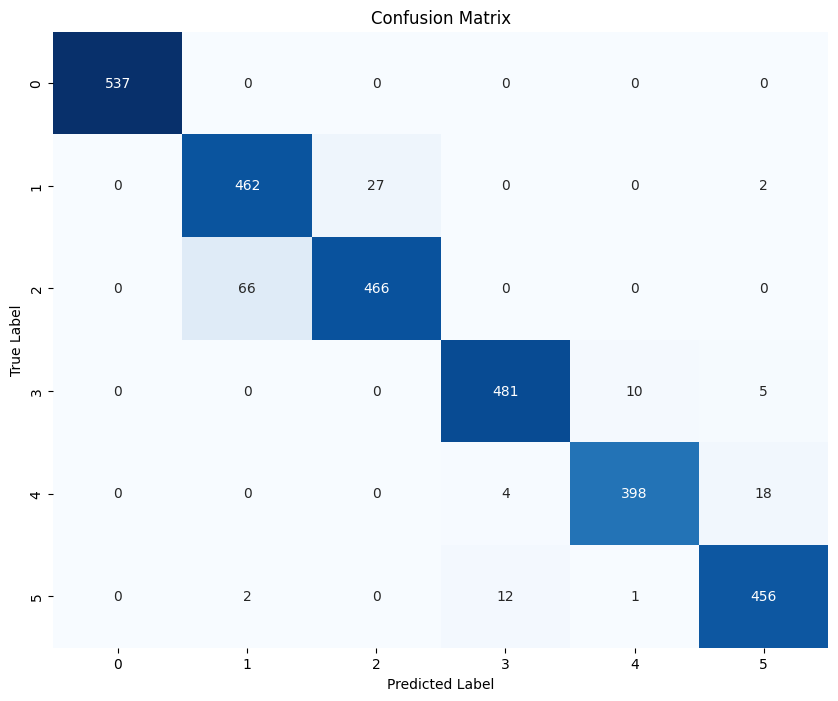

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

confusion_matrix = confusion_matrix_metric.compute().cpu().numpy()

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

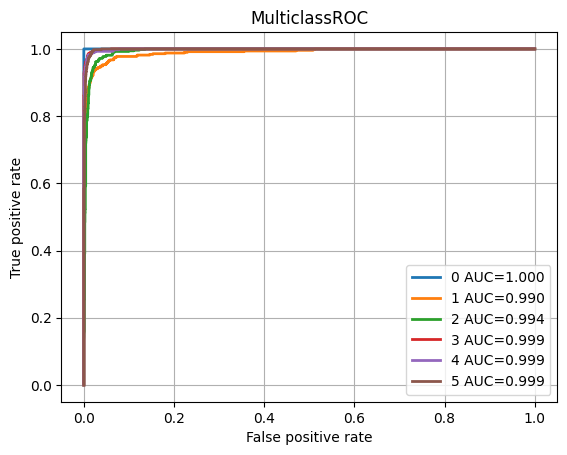

In [30]:
fig_, ax_ = roc_metric.plot(score=True)